In [1]:
# import necessary libraries
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import normalize
from scipy.sparse.linalg import eigsh
from scipy.signal import find_peaks
from scipy.spatial import Delaunay
from scipy.spatial import distance
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import multiprocessing as mp
from sklearn import metrics
import networkx as nx
import numpy as np
import random
import csv
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

In [2]:
%run ./functions_for_GrapHiC.ipynb

In [9]:
def calling_graphic(data, sigma_s = 30.0, noise_thresh = 0.5):
    P1 = data[['x', 'y']].to_numpy() # select the coordinates columns, and transform into a numpy object
    truelabels = data['labels_1'].to_numpy()

    Sigma1          = np.ones((P1.shape[0], 2, 2)) * 0.5
    Sigma1[:, 0, 1] = 0
    Sigma1[:, 1, 0] = 0
    n1              = np.ones((P1.shape[0], 1)).ravel()

    density1, noise_points1, not_noise_points1, G0 = denoise(P1, Sigma1, sigma_s, noise_thresh, 1)
    labels1, G1, k1 = cluster_single_scale(P1, Sigma1, not_noise_points1, sigma_s, 1)
    #plot_the_graph(G0, P1, 'Delaunay Graph', 1)
    #plot_the_graph(G1, P1[not_noise_points1], 'Delaunay Graph', 1)
    labels1_fid     = labels1
    #plot_points(P1, labels1, 'First scale - ' + str(k1) + ' clusters', 2)
    #plot_clusters_with_graph(G1, P1[not_noise_points1], labels1_fid[not_noise_points1], '1st scale clusters with graph', 1)
    labels1_fid += 1 # to match the convention
    return labels1_fid

In [4]:
class Point():
    def __init__(self,x,y):
        self.x = x
        self.y = y
        self.label = []
        
        self.x_collected, self.y_collected = x,y # by default, if the point undergoes no perturbation, the coordinates collected are the GT coordiantes 
        
    def add_label(self, label_to_add):
        self.label.append(label_to_add)
        
        
    def Scramble(self, delta):
        mean = [0,0]
        delta = delta + np.random.normal(0, 2) # delta should be random, and different for each point. 
        cov_scramble = [[delta**2, 0], [0, delta**2]]
        coord_collected     = np.sum([np.array([self.x,self.y]),
                                        np.random.multivariate_normal(mean, cov_scramble)],
                                        axis = 0)
        self.x_collected = coord_collected[0]
        self.y_collected = coord_collected[1]
        
    def GetCoord(self):
        return np.array([self.x_collected,self.y_collected])
    
    def GetCoord_GT(self):
        return np.array([self.x,self.y])
    
    def Isin(self, cluster, delta = 2):
        diff = cluster.center -  self.GetCoord_GT()
        if np.linalg.norm(cluster.center -  self.GetCoord_GT()) < (cluster.radius + delta): return True
        else: return False 
        

In [5]:
class Cluster():
    def __init__(self, center, radius, label):
        self.center = center
        self.radius = radius
        self.points = []
        self.label  = label
        
        
    def Fill(self, NumberOfPoints, cluster_shape):
        
        if cluster_shape == 'uniform':
            temp = uniform_cluster(self.radius, NumberOfPoints, self.center)
        if cluster_shape == 'gaussian':
            temp = gaussian_cluster((self.radius / 2), NumberOfPoints, self.center)
            
        for t in temp: 
            new_point = Point(x = t[0], y = t[1])
            new_point.add_label(self.label)
            self.points.append(new_point)

In [6]:
class DataGenerator2():
    
    def __init__(self,
                 dist,
                 NumberOfClusters, LocPerCluster, r, SNR,
                 NumberOfScales = 1,
                 delta = 1,
                 x_lim = [-5, 5], y_lim = [-5, 5],
                 cluster_shape = 'uniform',
                 UniformNoise = True):
        
        # frame shape
        self.xmin, self.xmax = 1000 * x_lim[0], 1000 * x_lim[1] # from micrometer to nanometer 
        self.ymin, self.ymax = 1000 * y_lim[0], 1000 * y_lim[1]
        
        # parameters 
        self.NumberOfClusters = NumberOfClusters
        self.numbers          = LocPerCluster
        self.dist             = dist
        self.r                = r
        #self.IsolatedLoc      = IsolatedLoc
        self.cluster_shape    = cluster_shape
        self.delta            = delta 
        self.SNR              = SNR
        self.IsolatedLoc      = int(sum(LocPerCluster) / self.SNR)
        
        # initialise an exmpty clusters list: 
        self.Clusters = []
        
        # initialise a empty list of Isolated points:
        self.IsolatedPoints = []
        

        
        #for s in range(NumberOfScales):
        #    print('s = ', s )
        
        # data generation steps
        self.CreateClusters()
        
            
    def PlaceCenters(self):
        self.centers = np.array([[0,0], [self.dist, 0]])
            
    def InitializeClusters(self):
        # Creates the Cluster objects
        for i, center in enumerate(self.centers):   
            self.Clusters.append(Cluster(center, self.r[i], label = i+1))    # first cluster has label = 1. Label = 0 indicates noise. 

    def FillClusters(self):
        # This method calls the Fill method for each cluster. Fill will create n points in the cluster. 
        for i, cluster in enumerate(self.Clusters):
            if (self.cluster_shape != 'uniform') and (self.cluster_shape != 'gaussian'): print('cluster_shape must be "uniform" or "gaussian"')
            else: cluster.Fill(self.numbers[i], self.cluster_shape)
        
    def Scramble(self):
        for cluster in self.Clusters:
            for point in cluster.points: 
                point.Scramble(self.delta)
    
    def CreateClusters(self):
        self.PlaceCenters()
        self.InitializeClusters()
        self.FillClusters()
        self.Scramble()
        
    
    def AddIsolatedLoc(self):
        # This method creates Isolated points, randomly distributed, but avoiding the cluster areas. 
        n = 0  # n counts the number of isolated locations that are added to the data
        
        while n < self.IsolatedLoc:
            new_noise = np.random.uniform(low=[self.xmin, self.ymin], high=[self.xmax, self.ymax], size=(1,2))
            new_noise = Point(new_noise[0][0], new_noise[0][1]) # putting it in a Point variable, to use its methods.
            new_noise.add_label(0)  # 0 label is for noise
            
            # If the new point is in a cluster, discard it. 
            is_accepted = True 
            for cluster in self.Clusters: 
                if new_noise.Isin(cluster, delta = self.delta): is_accepted = False
                
            if is_accepted: 
                self.IsolatedPoints.append(new_noise)
                n += 1
        
    def GetPointsCoord(self):
        # returns in an  numpy array the info about all cluster points + noise points
        points  = np.array([[0, 0]]) 
        
        # Points from the Clusters
        for cluster in self.Clusters:
            for p in cluster.points: 
                points = np.vstack([points, p.GetCoord()]) # extend the array with next points
                
        # Isolated Points
        for isolated in self.IsolatedPoints: 
            points = np.vstack([points, isolated.GetCoord()])
        
        return points[1:]
            
    def GetPointsLabels(self):
        labels = []
        for cluster in self.Clusters: 
            for p in cluster.points: 
                labels.append(p.label[0])
                
        for isolated in self.IsolatedPoints:
            labels.append(isolated.label[0])
        return labels
    
    def plot_points(self, dot_size = 1):
        P1              = self.GetPointsCoord()
        labels          = self.GetPointsLabels()
        plot_points(P1, labels, 'Input Data: GT', dot_size)
        plot_points(P1, len(labels) * [0], 'Input Data', dot_size)
    
    def save_fig_pdf(self, path, filename = 'generated_SMLM_untitled', dot_size = 0.01):
        P1              = self.GetPointsCoord()
        labels          = self.GetPointsLabels()
        save_fig_pdf(P1, labels, path, filename, dot_size)
        
    def GetAllData(self):
        # concatenate the positions and the label associated, in a pandas dataframe variable,
        # with columns names: x, y, labels_1, ..., labels_s, s the number of scales 
        df_xy    = pd.DataFrame(self.GetPointsCoord(), columns = ['x','y'])
        df_l     = pd.DataFrame(self.GetPointsLabels(), columns= ['labels_1'])
        df_final = pd.concat([df_xy, df_l], axis = 1)
        return df_final
        
    def save_to_csv(self, path, filename):
        # This function saves a .csv file with columns: x, y, and labels. Each row corresponds to one point.
        # Give the filename without .csv, and the path without / 
        # Il faudra ajouter une autre colonne pour toutes les autres échelles

        df_final = self.GetAllData()
        df_final.to_csv(path + '/' + filename + '.csv', index = False)

In [7]:
def Call_DataGenerator(p):
    datagen = DataGenerator2(x_lim = p.x_lim,
                        y_lim = p.y_lim,
                        dist = p.dist,
                        NumberOfClusters = p.NumberOfClusters,
                        LocPerCluster = p.LocPerCluster,
                        r = p.r,
                        SNR = p.SNR,
                        NumberOfScales = p.NumberOfScales,
                        delta = p.delta,
                        cluster_shape = p.cluster_shape,
                        UniformNoise = p.UniformNoise)
    return datagen

In [8]:
class Param():
    def __init__(self, dist = 100):
        # Region of interest :
        self.x_lim = [0, 4] # micrometer
        self.y_lim = [0, 4]

        # Clusters :
        self.NumberOfClusters = 2
        self.LocPerCluster    = [100] * self.NumberOfClusters
        self.r                = [30] * self.NumberOfClusters # nm
        self.dist             = dist
        self.delta            = 20 #nm
        self.cluster_shape    = 'uniform'

        # Noise :
        self.SNR              = 1
        self.UniformNoise     = True 
        
        # Scales : 
        self.NumberOfScales   = 1

In [115]:
p50 = Param(50)
datagen50 = Call_DataGenerator(p50)

p70 = Param(70)
datagen70 = Call_DataGenerator(p70)

p100 = Param(100)
datagen100 = Call_DataGenerator(p100)

p150 = Param(150)
datagen150 = Call_DataGenerator(p150)

p200 = Param(200)
datagen200 = Call_DataGenerator(p200)

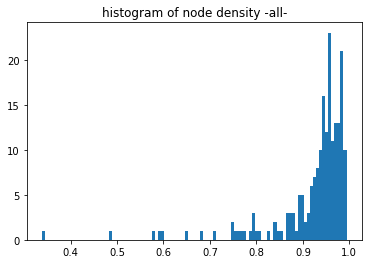

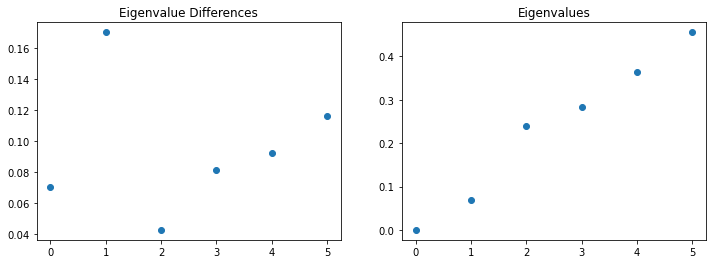

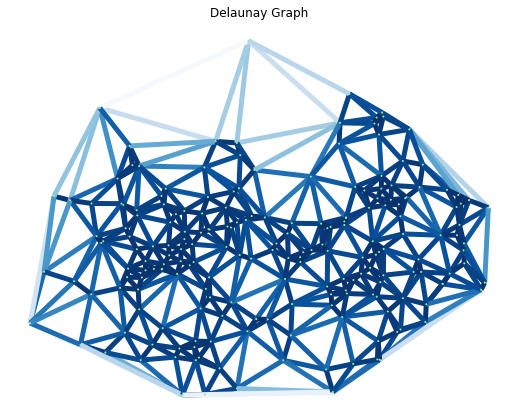

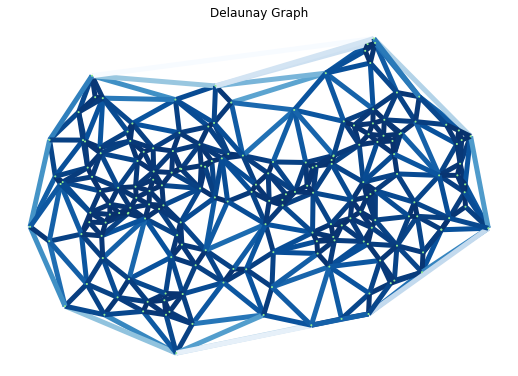

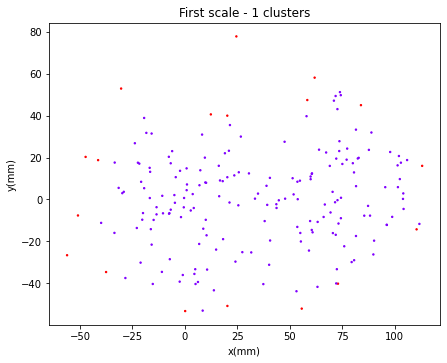

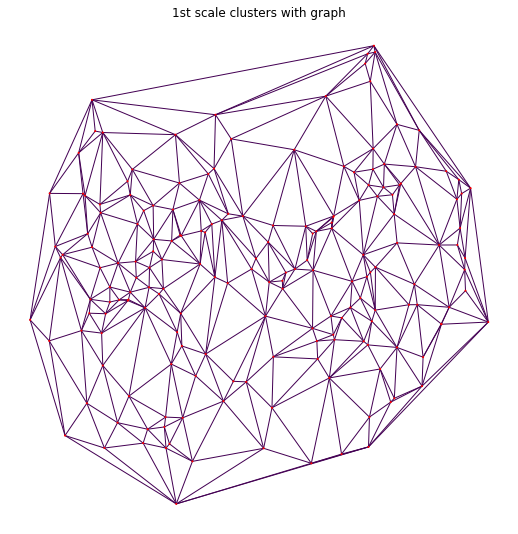

array([1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1.,
       1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [122]:
calling_graphic(datagen70.GetAllData(), sigma_s = 30, noise_thresh = 0.8)

50


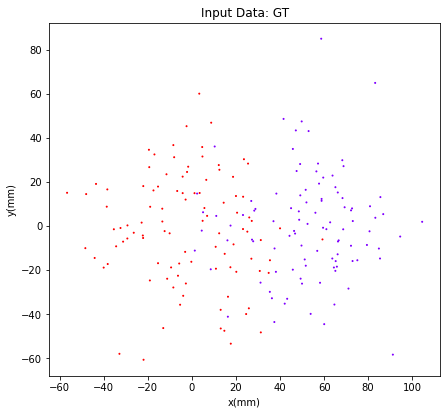

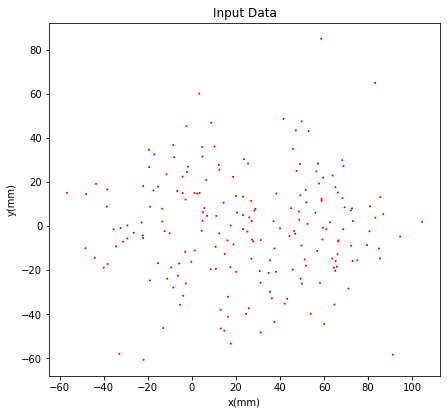

70


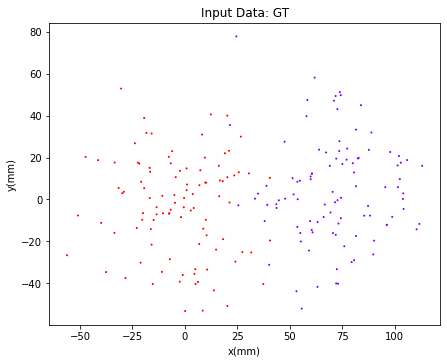

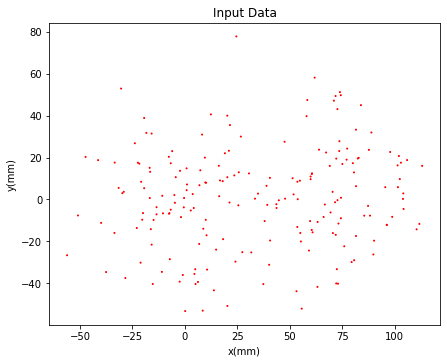

100


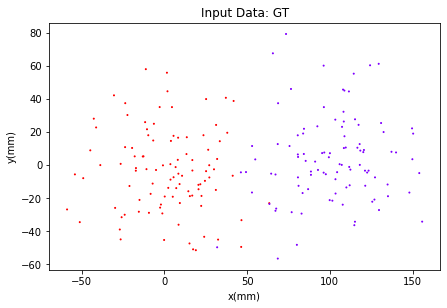

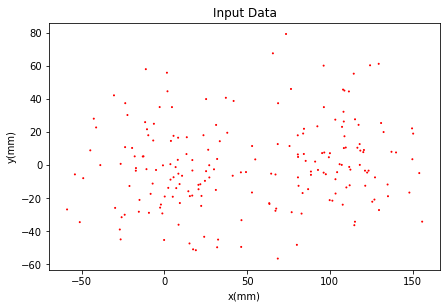

150


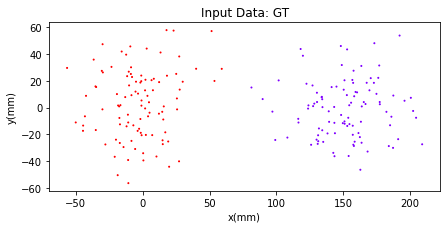

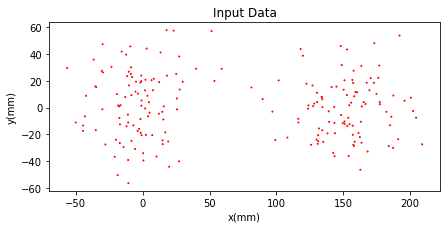

200


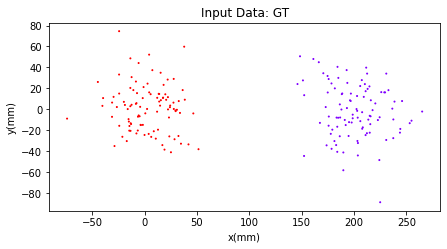

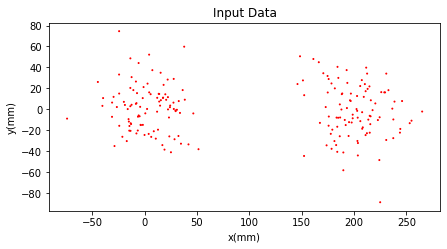

In [117]:
print('50')
datagen50.plot_points()
print('70')
datagen70.plot_points()
print('100')
datagen100.plot_points()
print('150')
datagen150.plot_points()
print('200')
datagen200.plot_points()

In [2]:
import numpy as np

In [ ]:
# Experiment paramters: 
distances = [60, 70, 75, 80, 85, 90, 95, 100, 105, 110, 120, 150, 200]
NumberOfSimulations = 30

# For Graphic:
sigma_s = 30.0
noise_thresh = 0.8

# For Tomato: 
tomato_path = '/Users/Eliana/Documents/PDM/Codes/My_codes/Power_Of_Seperation/DataForTomato'



Nclusters = []
FMIs      = []

for dist in distances:
    All_NumberOfClusters = []
    All_FMI = []
    
    for run in range(NumberOfSimulations):
        
        p = Param(dist)
        datagen = Call_DataGenerator(p)
        
        
        # --- Saving the in csv for ToMATo -----
        filename = 'sim_' + str(run) + '_dist_' + str(dist)
        datagen.save_to_csv(tomato_path, filename) # saving a csv file at each iteration
        
        # --- GrapHiC ---
        # counting the number of clusters, and adding the result to a list
        labels = calling_graphic(datagen.GetAllData(), sigma_s = 30, noise_thresh = 0.8)
        NumberOfClusters = max(labels)
        All_NumberOfClusters.append(NumberOfClusters)
        
        # To compute the FMI: 
        GT = datagen.GetAllData()
        truelabels = GT['labels_1'].to_numpy()
        FMI = metrics.fowlkes_mallows_score(truelabels, labels)
        All_FMI.append(FMI)

    mean_NumberOfClusters = sum(All_NumberOfClusters) / len(All_NumberOfClusters)
    mean_FMI = sum(All_FMI) / len(All_FMI)
    Nclusters.append(mean_NumberOfClusters)
    FMIs.append(mean_FMI)
        # DBscan

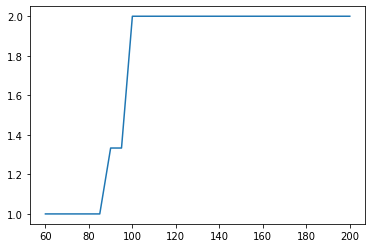

In [14]:
plt.plot(distances, Nclusters)


In [20]:
saving_path = '/Users/Eliana/Documents/PDM/Codes/My_codes/Power_Of_Seperation/'

# pos stands for power of seperation: 

graphic_pos_df = pd.DataFrame(distances, columns = ['dist'])
graphic_pos_df['Ncluster'] = Nclusters
graphic_pos_df['mean_FMI'] = FMIs
graphic_pos_df.to_csv(saving_path + 'graphic_PoS.csv', index = False)

[0.6376371608622237,
 0.6345205620966607,
 0.620529799485849,
 0.6441766018915268,
 0.6292402698351263,
 0.616106288686094,
 0.840207797064599,
 0.8597525241443728,
 0.8313725499993269,
 0.8591392344280051,
 0.8441437861053871,
 0.8503209078558434]

In [250]:
# ------------ DBSCAN ------------

distance = 150

p = Param(distance)
datagen = Call_DataGenerator(p)
df = datagen.GetAllData()
Points = df[['x', 'y']].to_numpy() # select the coordinates columns, and transform into a numpy object



db                = DBSCAN(eps=20, min_samples=5).fit(Points)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels_db         = db.labels_

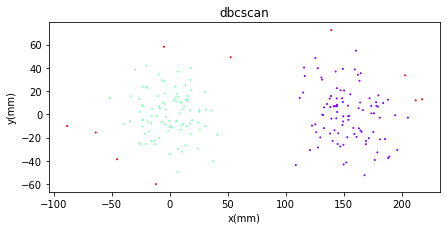

In [251]:
plot_points(Points, labels_db,'dbcscan', 1)

In [254]:
liste = [3,4,5]
sum(liste)/len(liste)

4.0

In [268]:
datagen.GetAllData()

,x,y,labels_1
0,-16.503437,-27.370013,1
1,7.029558,48.653732,1
2,1.088543,7.319295,1
3,-42.451474,19.856365,1
4,6.982113,-5.534680,1
...,...,...,...
195,132.436542,37.298420,2
196,149.900150,-8.607936,2
197,197.256984,1.993556,2
198,131.292499,36.319163,2


In [21]:
r = 3
d = 120
filename = 'sim_' + str(r) + '_dist_' + str(d)

'sim_3_dist_120'